In [1]:
## region Import Dependencies and define functions:
import warnings
warnings.filterwarnings('ignore')
import datetime

# For data processing & plotting:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time as timer  # for timing code cells.
from scipy import stats
from scipy.signal import find_peaks
from scipy.stats import entropy
from scipy.signal import detrend

# For ML:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SequentialFeatureSelector  # For sequential feature sel.
from sklearn.model_selection import GridSearchCV, KFold, train_test_split  # To do parameter search
from sklearn import metrics
from sklearn.metrics import classification_report as rprt

# Classifiers for CPU based computing:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.linear_model import RidgeClassifier, LogisticRegression, Perceptron
from sklearn.metrics import confusion_matrix

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.grid'] = True
plt.rcdefaults()

# Only for GPU based computing: [ comment out on CPU ]
# import os  # Need both of these, run before importing cuml.

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# from cuml.svm import SVC
# from cuml.neighbors import KNeighborsClassifier
# from cuml.ensemble import RandomForestClassifier
# from sklearn.linear_model import RidgeClassifier

66080


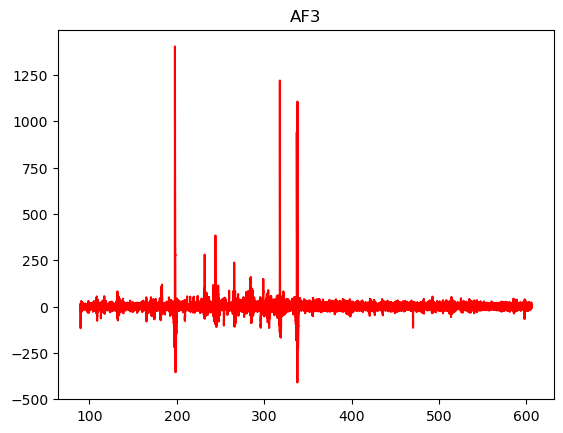

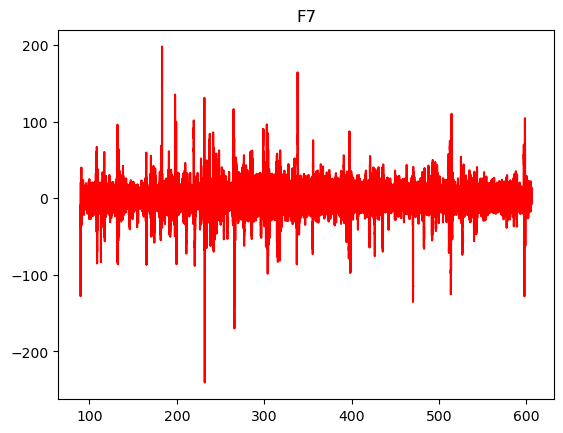

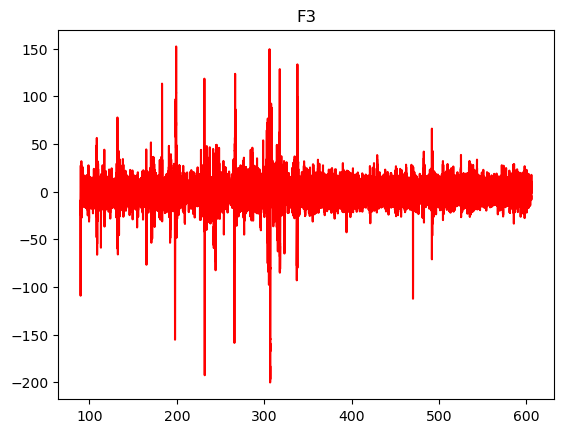

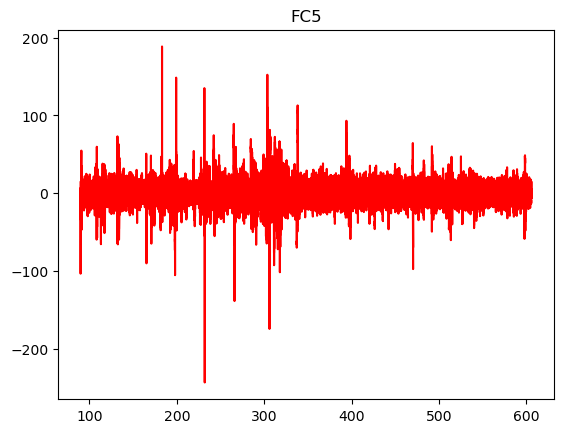

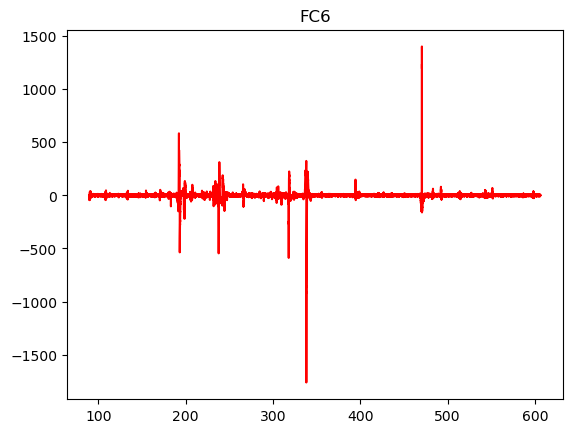

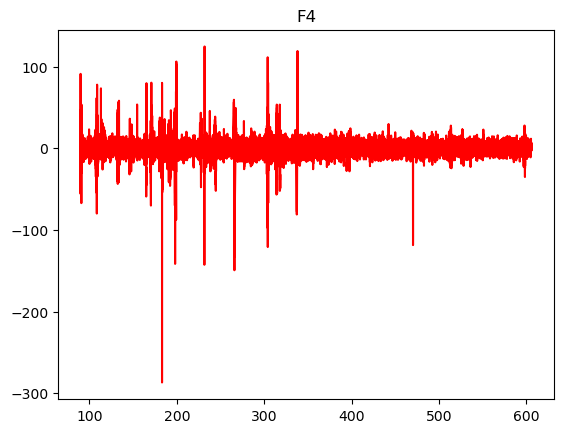

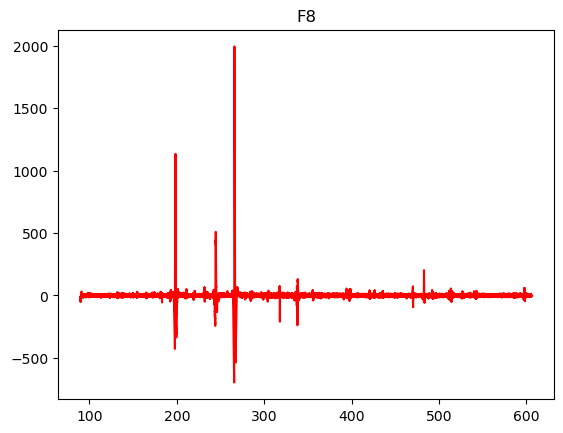

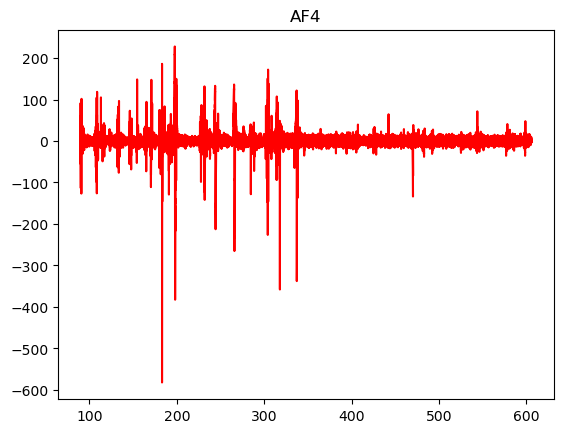

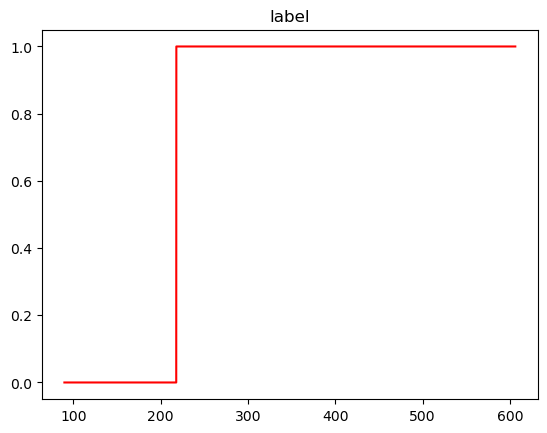

In [5]:
df=pd.read_csv('Sangwon.csv')
time= df.iloc[:, 0]/1000
eye_open_time=89.747827
eye_close_time=217.802844
time=time[time>89.747827]
index_start= time.index[1]
channel_data=df.iloc[(index_start-1):, 1:]    
labels=np.zeros((len(time), 1), dtype=int)
length=len(labels)
print(length)

channel_data=channel_data.reset_index(drop=True)
channel_data.head()
time=time.reset_index(drop=True)
time.head()
for i in range(length):
     if time[i]> eye_close_time:
        labels[i]=1
channel_data['label']=labels
for i in channel_data.columns:
     plt.plot(time, channel_data.loc[:,i], 'red')
     plt.title(i)
     plt.show()

In [2]:
def get_data(File_name, event1, event2):  # Filename is a string in colons. event 1 is start of eye open, event2 is start of eye close
    df=pd.read_csv(File_name)
    time= df.iloc[:-1000, 0]/1000
    CPT_start=event1
    Duration= event2
    time=time[time>10]
    index_start= time.index[0]  # randomly removing initial artifact
    channel_data=df.iloc[(index_start):-1000, 1:]    
   
    channel_data=channel_data.reset_index(drop=True)
    time=time.reset_index(drop=True)
    
    labels=np.zeros((len(time), 1), dtype=int)
    length_of_data=len(labels)
    
    for i in range(length_of_data):
         if time[i]> CPT_start and time[i]<CPT_start+Duration:
            labels[i]=1
    
    channel_data['label']=labels
    title_name=File_name.replace('.csv',"")
    fig, axs = plt.subplots(nrows=15, ncols=1, figsize=(6,10))
    fig.suptitle(title_name)
    for i in range(len(channel_data.columns)):
        axs[i].plot(time, channel_data.iloc[:,i], 'red')
        axs[i].set_ylabel(f'{channel_data.columns[i]}')
        
    plt.show()
    return channel_data, time, labels

def merge_data(data_to_be_merged, column_names):   

    merged_data = pd.DataFrame(columns=column_names)
   
    # merged_df = pd.concat([p1_df, p1_df], axis=0)
    # merged_df.columns
    # # plt.plot(merged_df.loc[:,'label'])
    # merged_df.loc[:,'label']
    
    
    for i in range(len(data_to_be_merged)):
        data_temp =data_to_be_merged[i]
        merged_data = pd.concat([merged_data, data_temp])

    #  Reset index
    merged_data.reset_index(drop=True, inplace=True)
    plt.plot( merged_data.loc[:,'label'])
    return  merged_data


In [3]:
def plot_data(merged_data):
    fig, axs = plt.subplots(nrows=15, ncols=1, figsize=(6, 10))
    fig.suptitle("Plot of all data channels")
    for i in range(np.shape(merged_data)[1]):
        axs[i].plot(merged_data.iloc[:, i], 'blue')
        x=merged_data.iloc[:,i]*merged_data.loc[:,'label']
        axs[i].plot(x, 'red')
        axs[i].set_title(merged_data.columns[i])
      
        
    return 
    

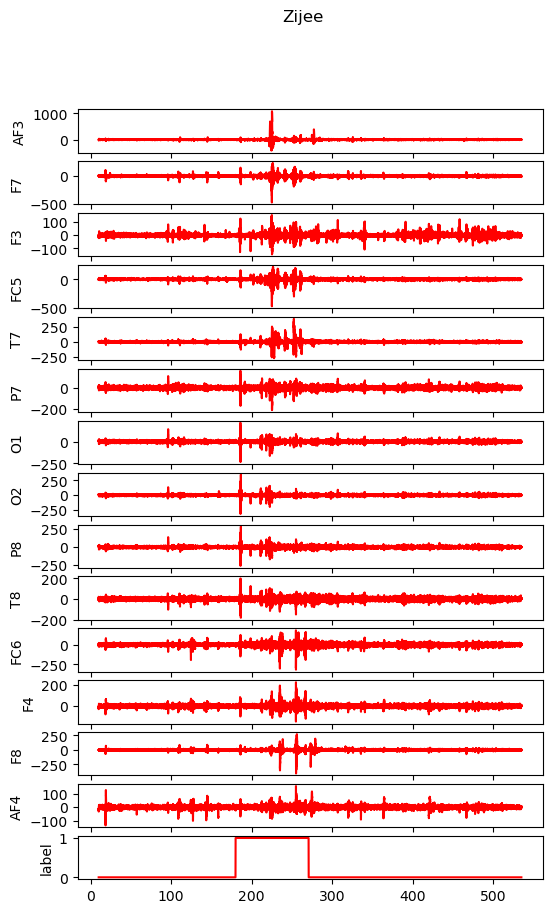

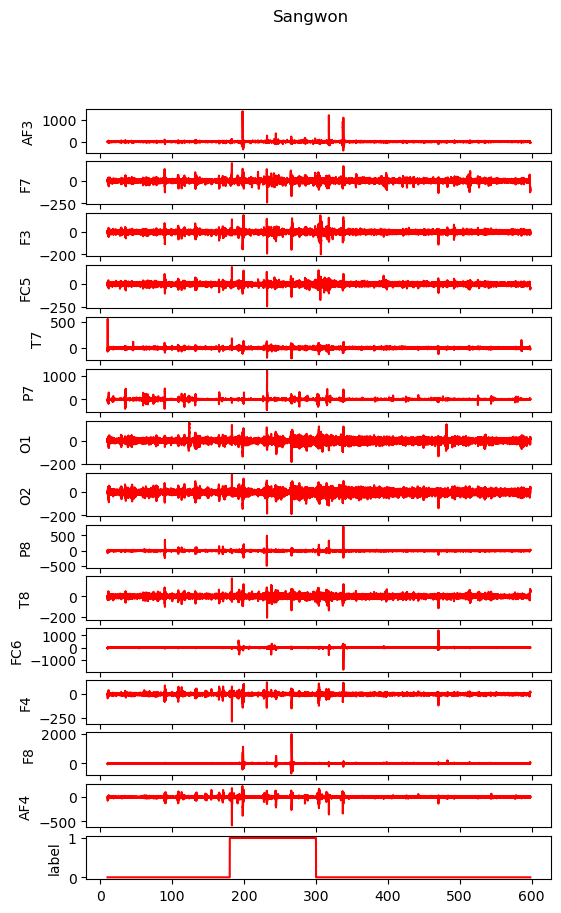

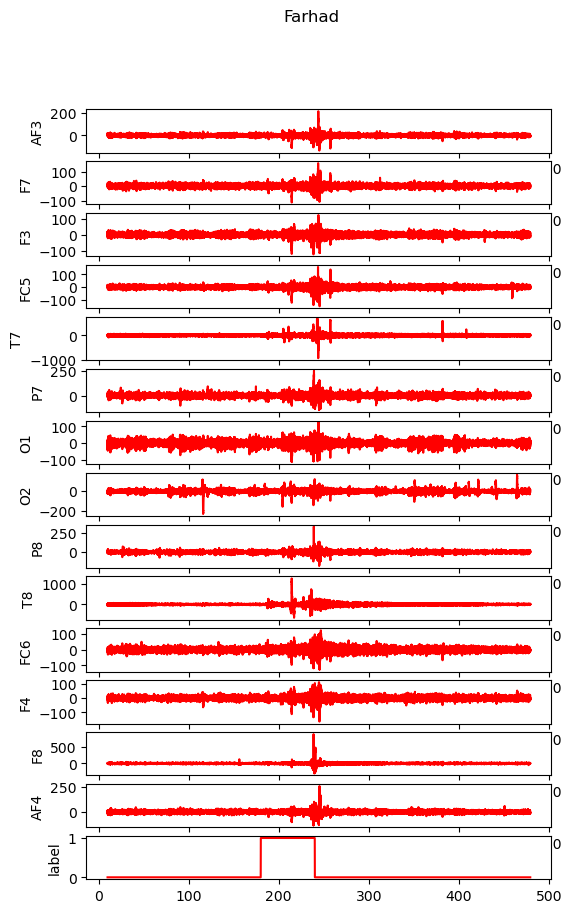

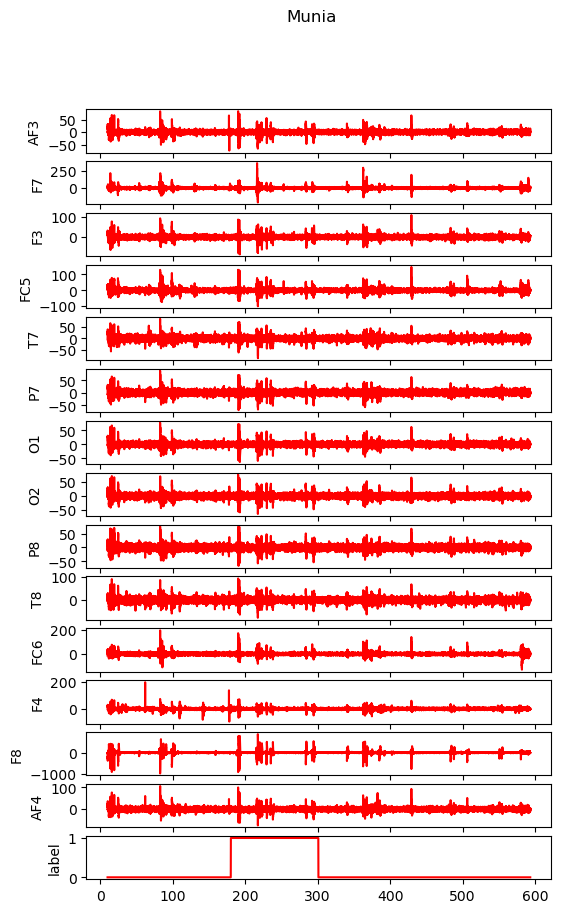

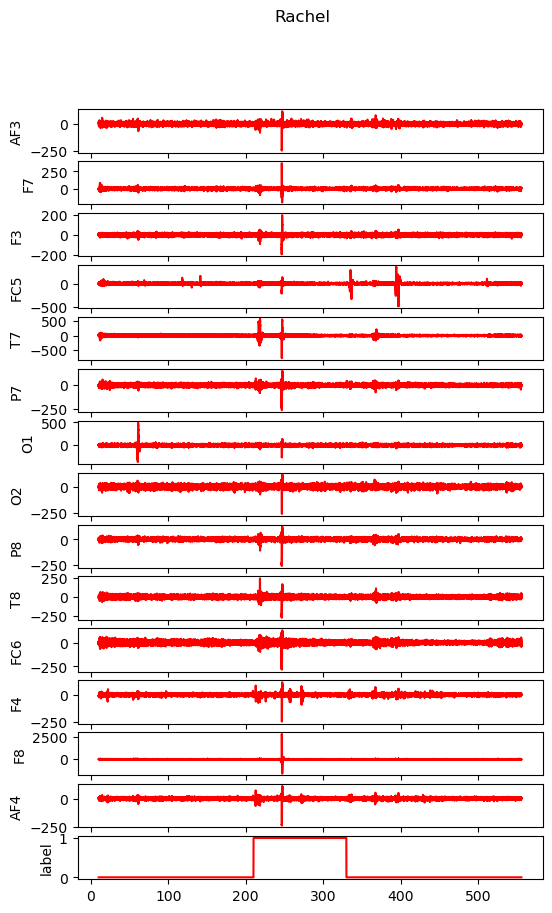

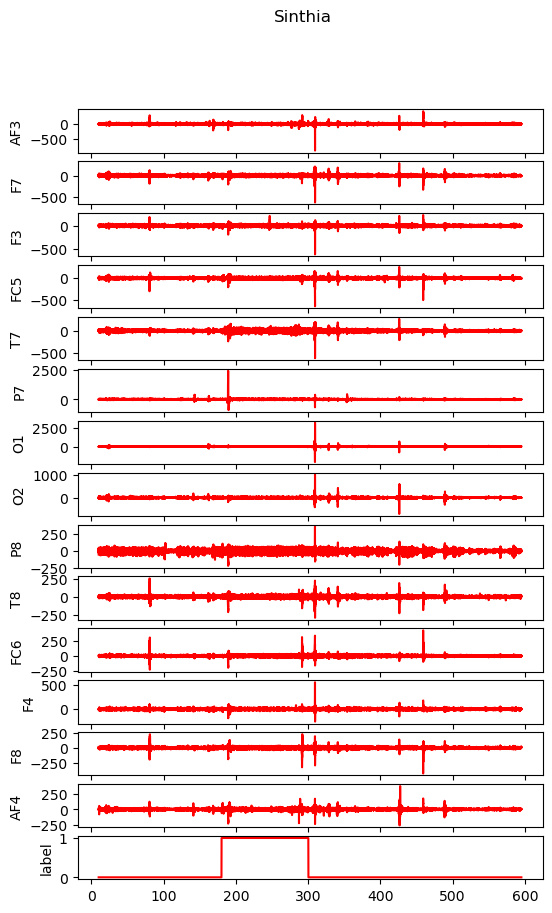

0        0
1        0
2        0
3        0
4        0
        ..
67218    0
67219    0
67220    0
67221    0
67222    0
Name: label, Length: 67223, dtype: int32

In [4]:
p1_df,p1_t, p1_label_value=get_data('Zijee.csv',180,90.802844)
p2_df,p2_t, p2_label_value=get_data('Sangwon.csv',180,120)
p3_df,p3_t, p3_label_value=get_data('Farhad.csv',180,60)
p4_df,p4_t, p4_label_value=get_data('Munia.csv',180,120.787151)
p5_df,p5_t, p5_label_value=get_data('Rachel.csv',210,120)
p6_df,p6_t, p6_label_value=get_data('Sinthia.csv',180,120.233147)



p1_df.loc[:,'label']




0         0
1         0
2         0
3         0
4         0
         ..
422021    0
422022    0
422023    0
422024    0
422025    0
Name: label, Length: 422026, dtype: object

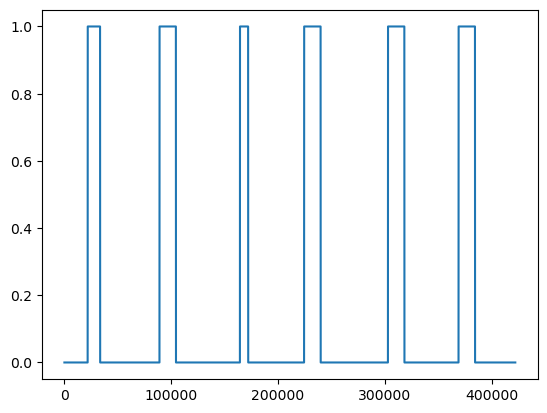

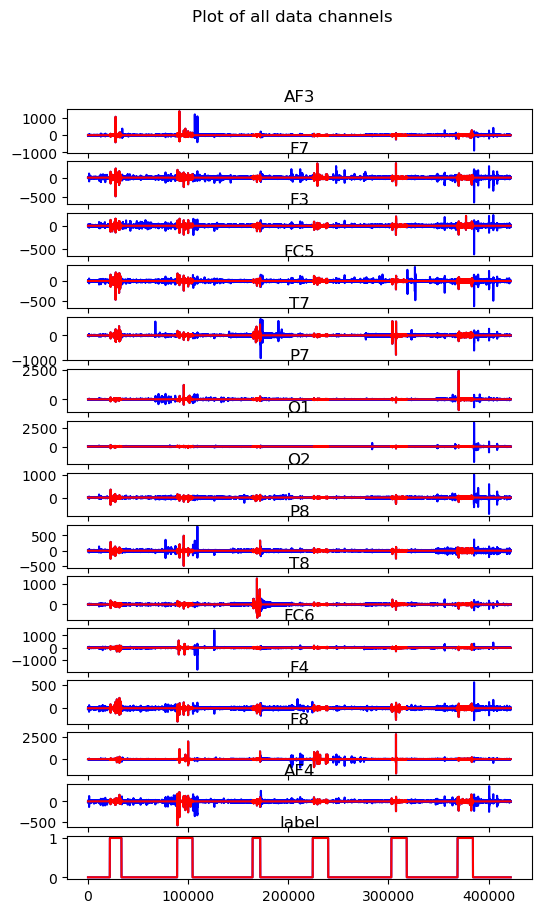

In [5]:
list_of_data=[p1_df, p2_df, p3_df, p4_df, p5_df, p6_df]
merged_data=merge_data(list_of_data, p1_df.columns)
plot_data(merged_data)
merged_data.loc[:,'label']

In [50]:
merged_data.columns
len(merged_data)

422026

In [17]:
# Define function to partition into windows and calculate window-wise metrics, using dataframe
def window_partition(data, window_size, overlap, column_names,  balanced=True):

    step_size = window_size - overlap
    new_data=pd.DataFrame(columns=column_names)
    label_list=[]
    for i in column_names:
        x=[]
        for j in range(0, len(data), step_size): 
            xs= data[i].values[j:j + window_size]
            x.append(xs)      
        new_data[i]=pd.DataFrame({i:x})
        new_data.reset_index(drop=True, inplace=True)
#     
    for j in range(0, len(data), step_size): 
            lab = stats.mode(data['label'].values[j:j + window_size])[0][0]
            label_list.append(lab)
    
#     plt.plot(label_list,'o')
#     plt.show()
    X = pd.DataFrame()

    for i in new_data.columns:   
        new_data_fft = new_data[i].apply(lambda x: np.abs(np.fft.fft(x))[0:])
        freq = new_data[i].apply(lambda x: np.abs(np.fft.fftfreq(window_size, d=1/128)))
        X[f'mean_fft{i}'] = new_data_fft.apply(lambda x: np.mean(x))
        # Max Freq Index
        X[f'max_freq_idx{i}'] = new_data_fft.apply(lambda x: np.argmax(x))
        # Min Freq Index [Ignore first entry since close to zero]
        X[f'min_freq_idx{i}'] = new_data_fft.apply(lambda x: np.argmin(x))
        # Entropy
        X[f'entr_fft{i}'] =new_data_fft.apply(lambda x: entropy(x))
        # std dev
        X[f'std_fft{i}'] = new_data_fft.apply(lambda x: x.std())
        # min [ignore zeros]
        X[f'min_fft{i}'] = new_data_fft.apply(lambda x: np.min(x[np.nonzero(x)]))
        # max
        X[f'max_fft{i}'] = new_data_fft.apply(lambda x: x.max())
        # median
        X[f'median_fft{i}'] = new_data_fft.apply(lambda x: np.median(x))
        # number of peaks
        X[f'peak_count_fft{i}'] = new_data_fft.apply(lambda x: len(find_peaks(x)[0]))
        # skewness
        X[f'skewness_fft{i}'] = new_data_fft.apply(lambda x: stats.skew(x))
        # kurtosis
        X[f'kurtosis_fft{i}'] = new_data_fft.apply(lambda x: stats.kurtosis(x))
        # energy
        X[f'energy_fft{i}'] = new_data_fft.apply(lambda x: np.sum(x ** 2) / 100)
    
#     for j in range(len(new_data_fft)):
#         plt.plot(freq[j], new_data_fft[j])   
#         plt.show()
    return  X, label_list
            

features, label_list=window_partition(merged_data, window_size=1800, overlap=0, column_names=['T7', 'P7', 'O1', 'O2', 'P8', 'T8'])



In [18]:
len(features)
cols=features.columns
print(cols)


Index(['mean_fftT7', 'max_freq_idxT7', 'min_freq_idxT7', 'entr_fftT7',
       'std_fftT7', 'min_fftT7', 'max_fftT7', 'median_fftT7',
       'peak_count_fftT7', 'skewness_fftT7', 'kurtosis_fftT7', 'energy_fftT7',
       'mean_fftP7', 'max_freq_idxP7', 'min_freq_idxP7', 'entr_fftP7',
       'std_fftP7', 'min_fftP7', 'max_fftP7', 'median_fftP7',
       'peak_count_fftP7', 'skewness_fftP7', 'kurtosis_fftP7', 'energy_fftP7',
       'mean_fftO1', 'max_freq_idxO1', 'min_freq_idxO1', 'entr_fftO1',
       'std_fftO1', 'min_fftO1', 'max_fftO1', 'median_fftO1',
       'peak_count_fftO1', 'skewness_fftO1', 'kurtosis_fftO1', 'energy_fftO1',
       'mean_fftO2', 'max_freq_idxO2', 'min_freq_idxO2', 'entr_fftO2',
       'std_fftO2', 'min_fftO2', 'max_fftO2', 'median_fftO2',
       'peak_count_fftO2', 'skewness_fftO2', 'kurtosis_fftO2', 'energy_fftO2',
       'mean_fftP8', 'max_freq_idxP8', 'min_freq_idxP8', 'entr_fftP8',
       'std_fftP8', 'min_fftP8', 'max_fftP8', 'median_fftP8',
       'peak_count_

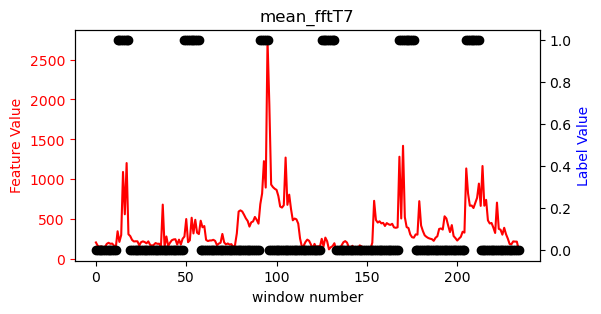

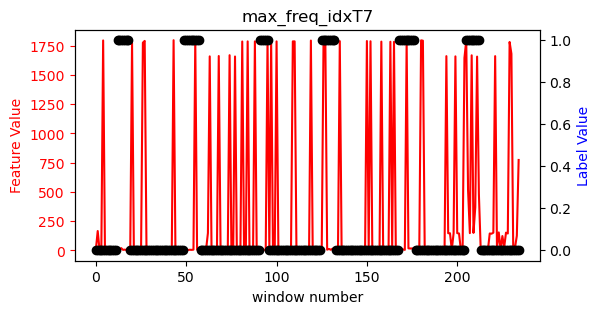

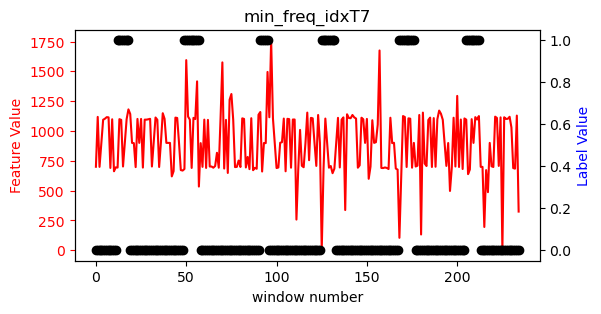

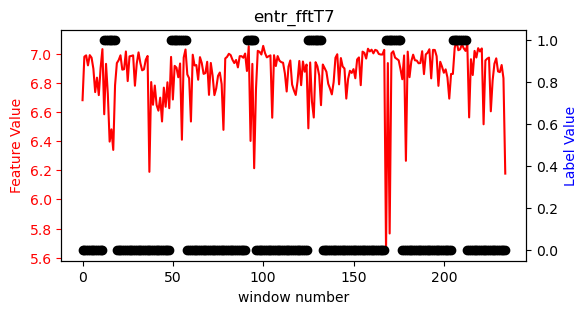

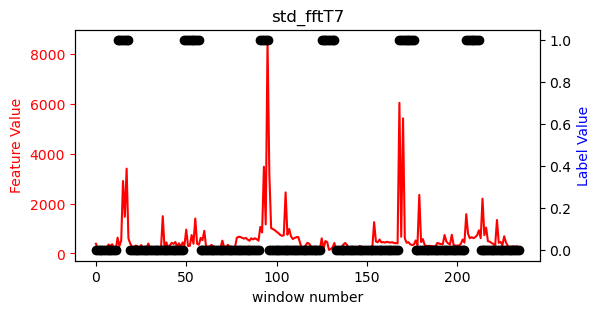

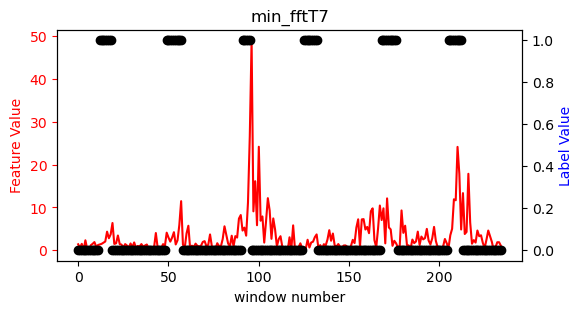

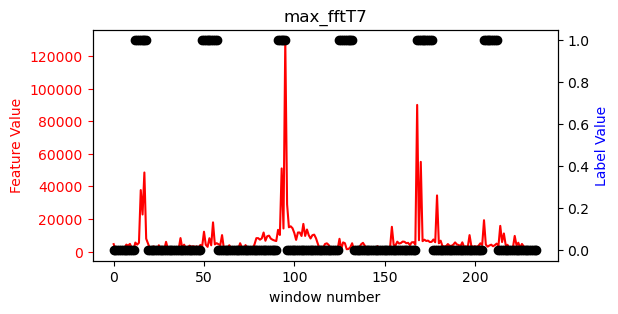

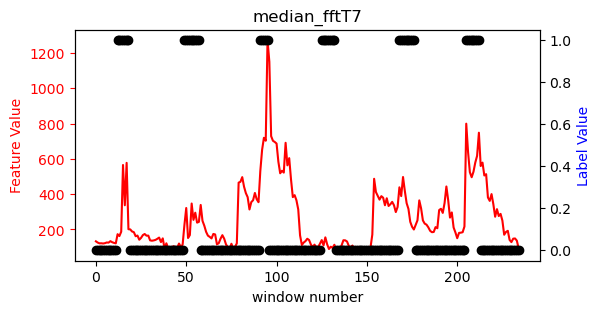

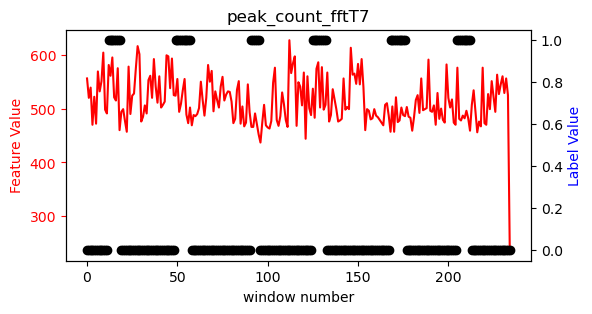

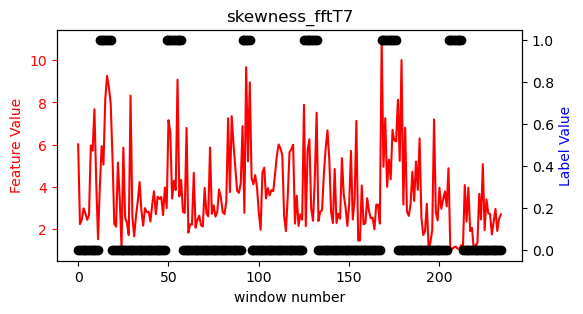

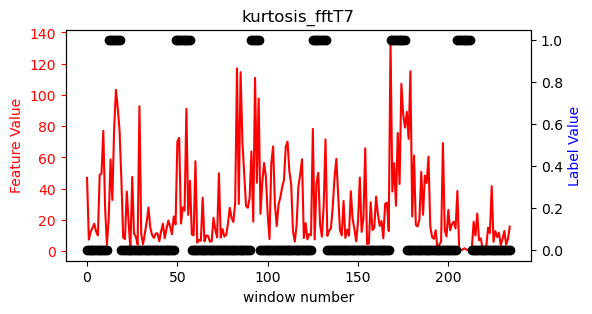

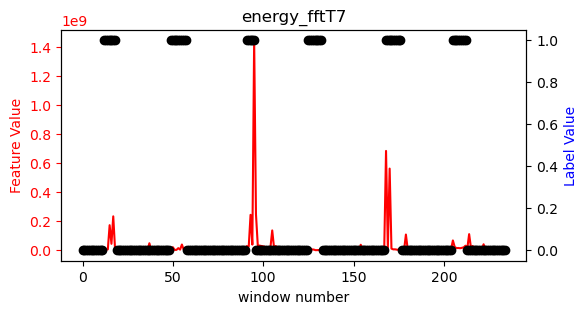

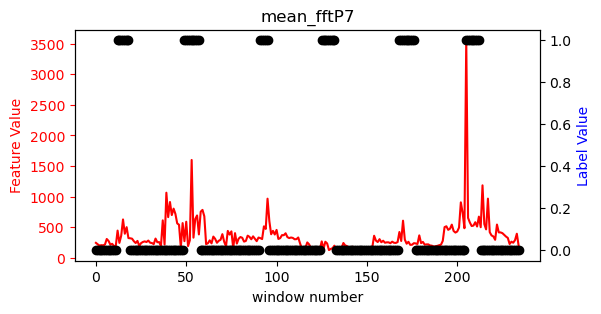

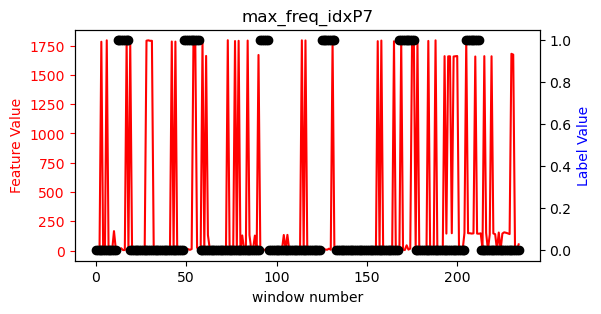

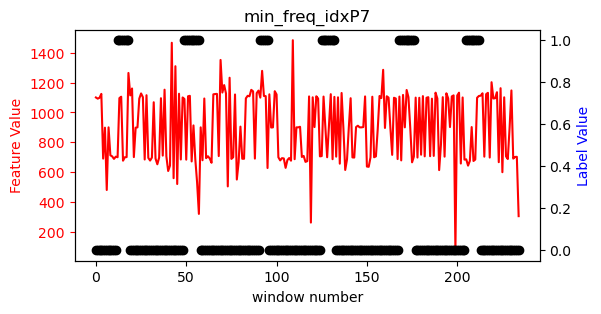

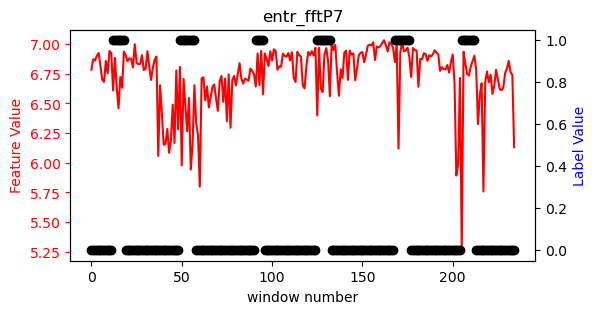

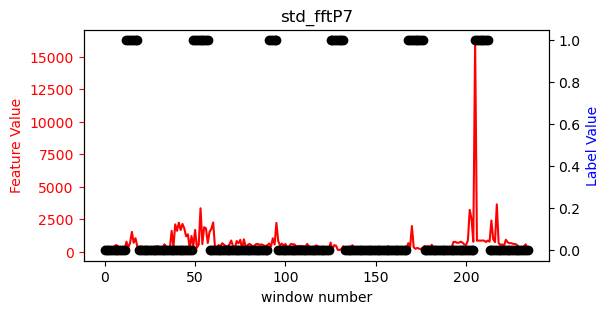

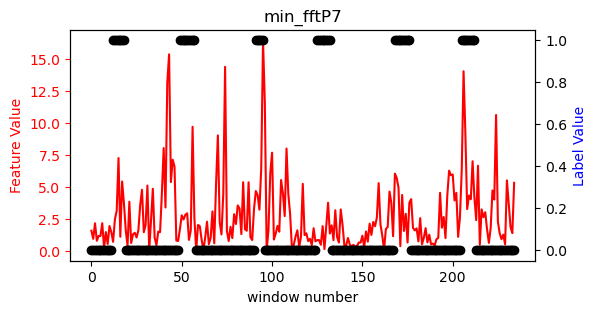

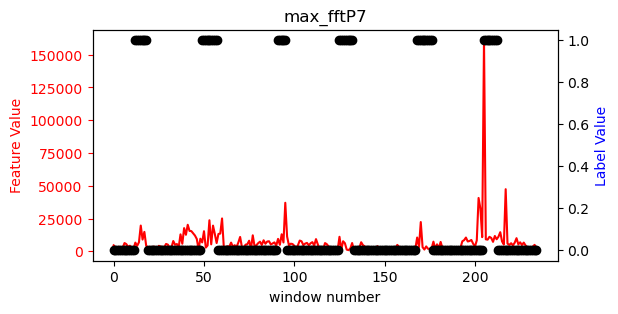

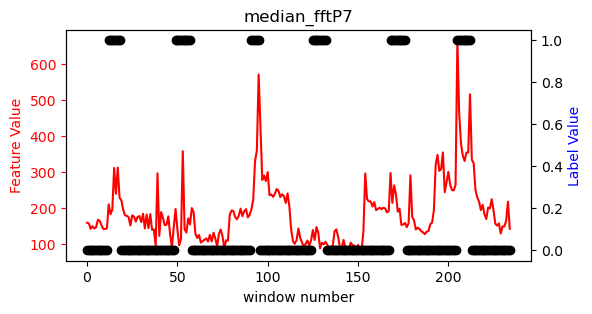

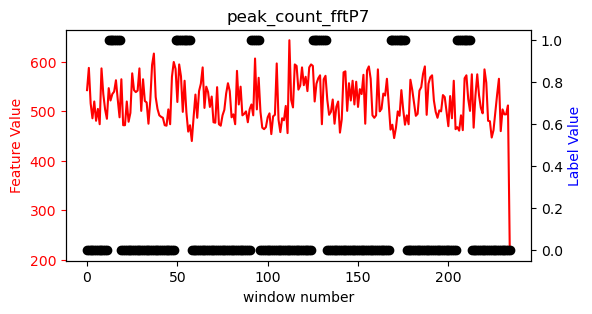

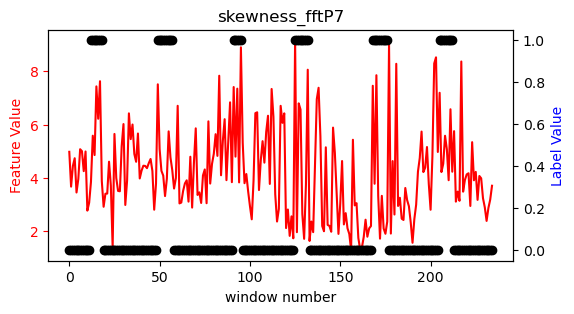

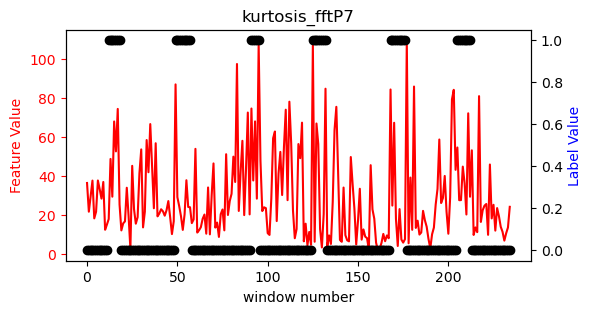

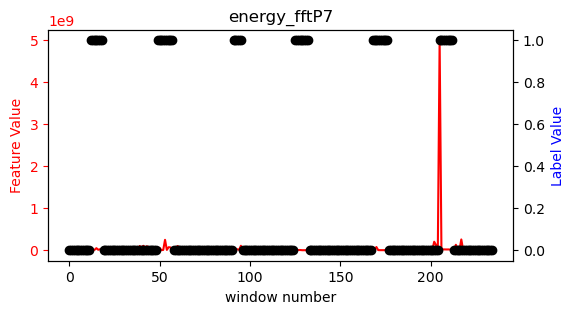

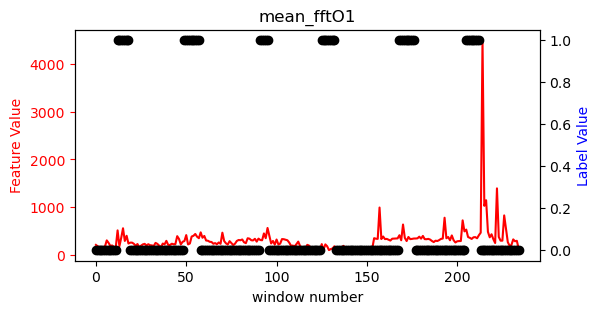

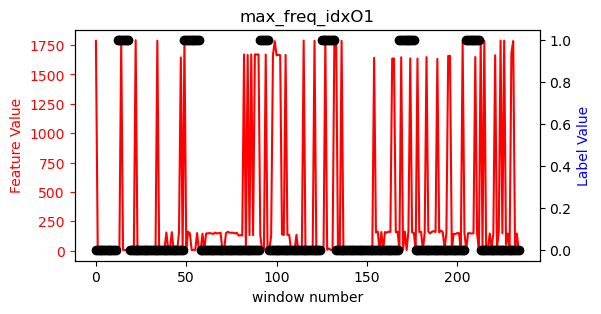

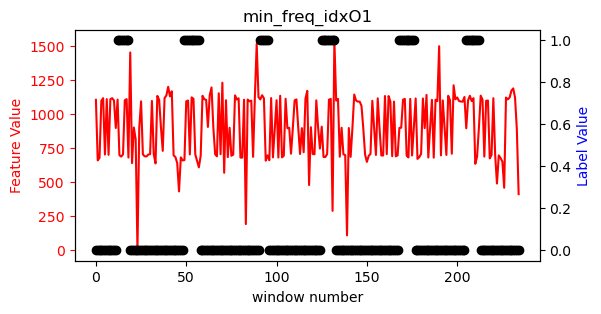

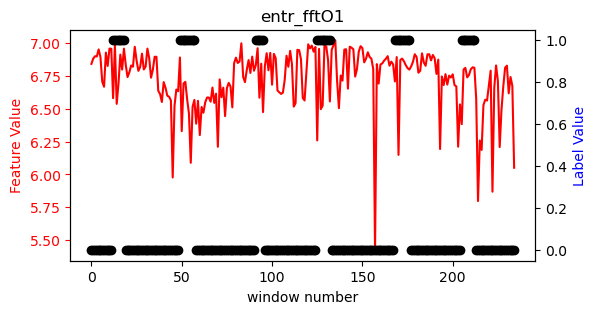

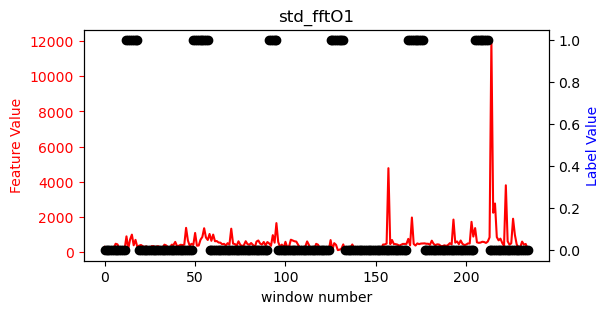

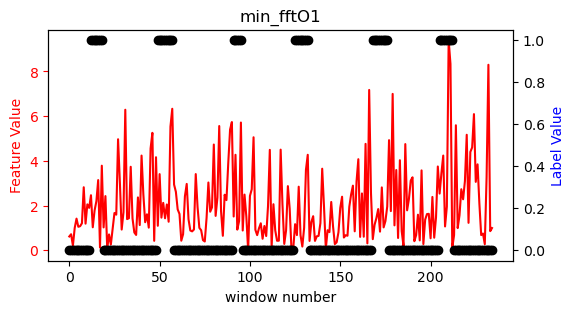

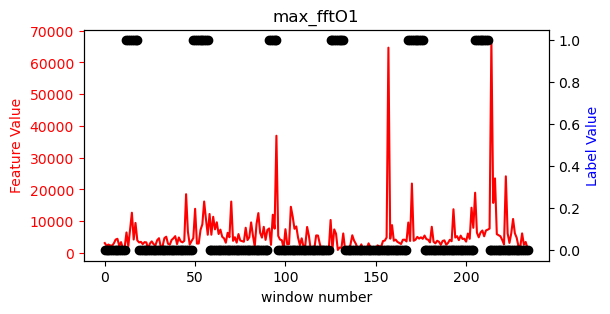

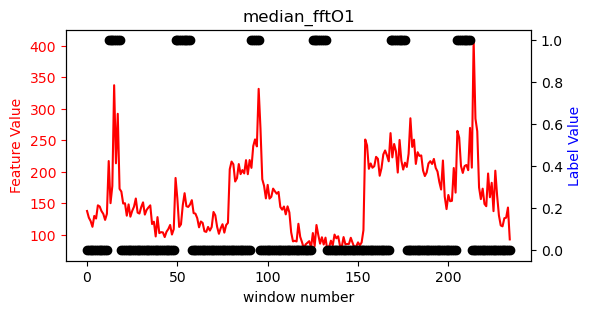

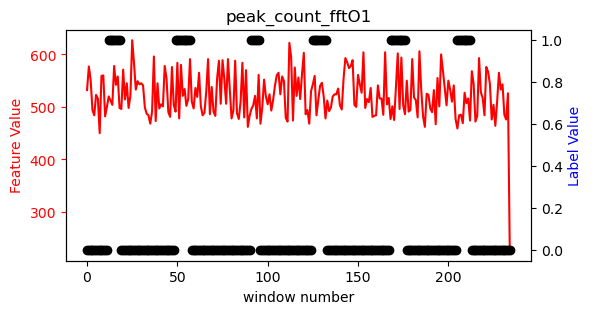

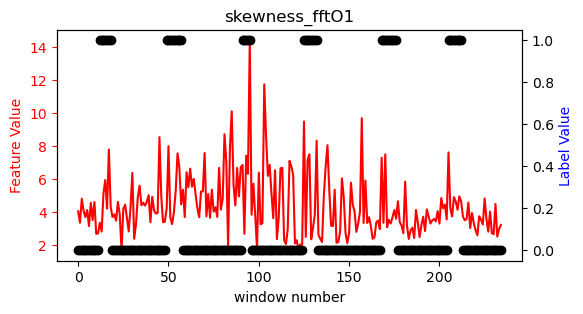

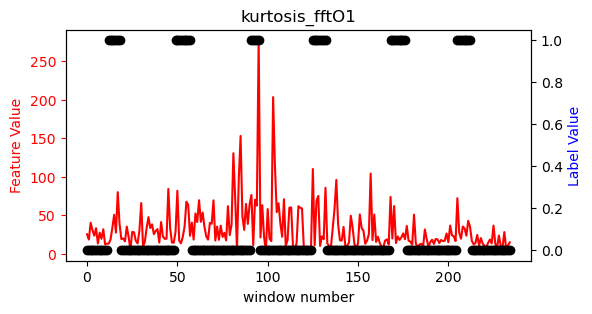

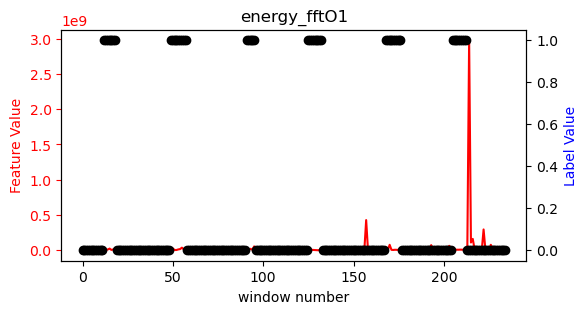

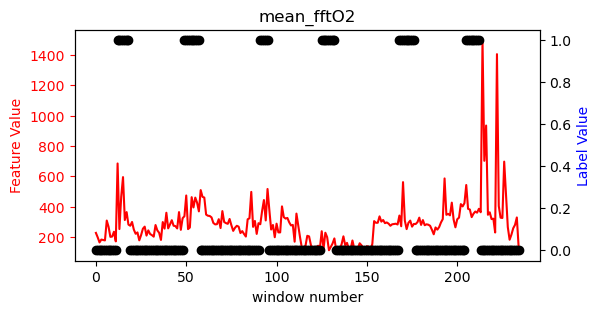

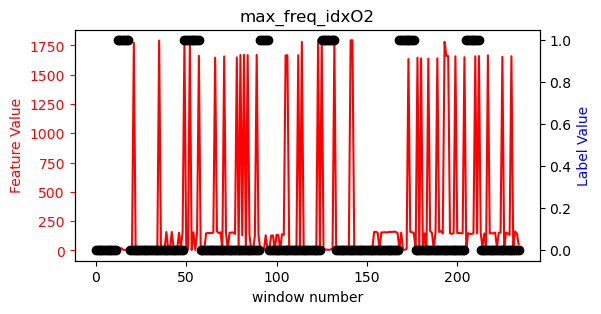

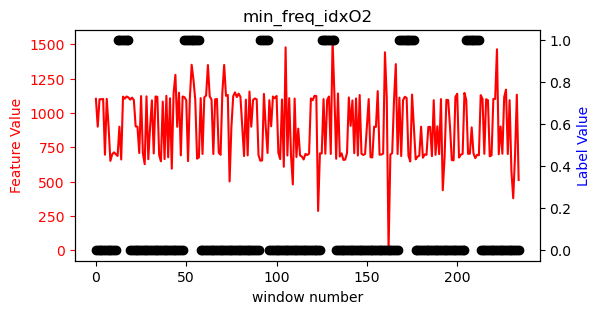

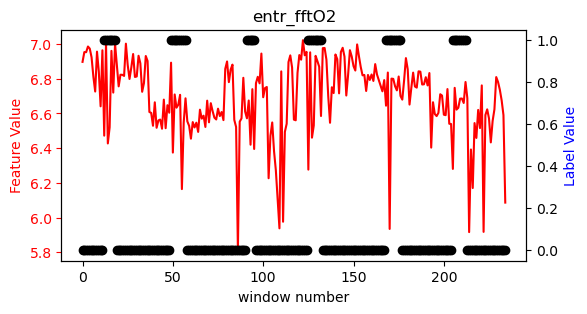

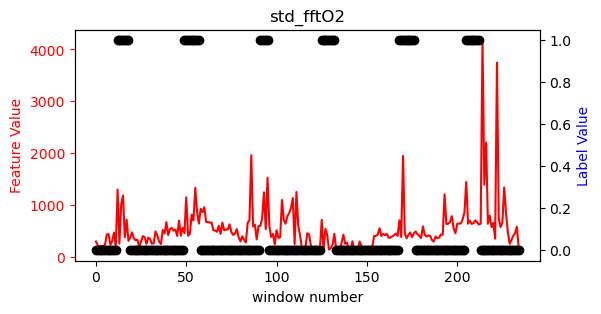

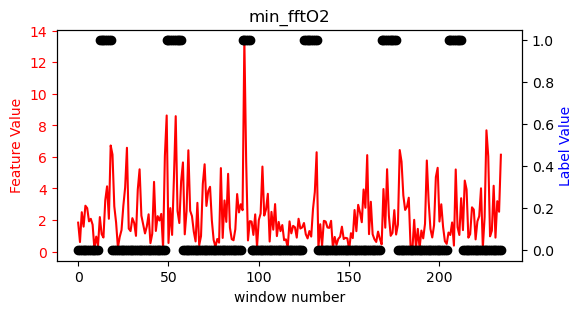

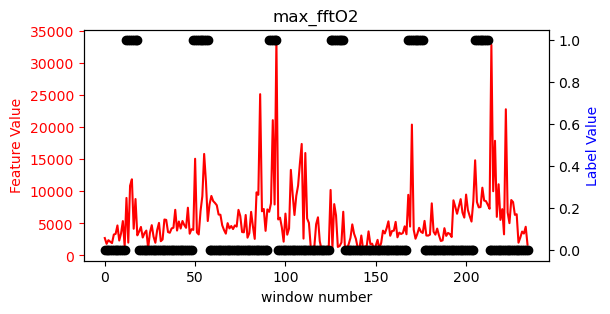

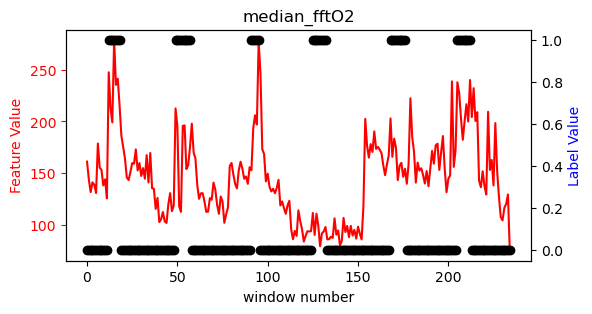

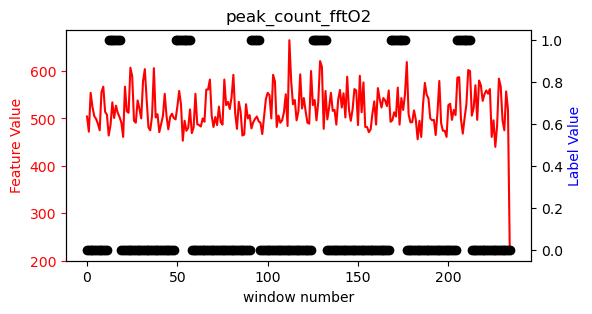

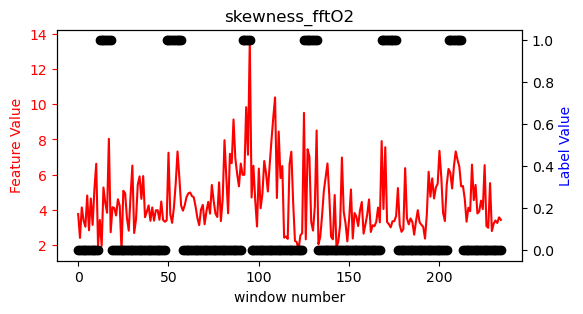

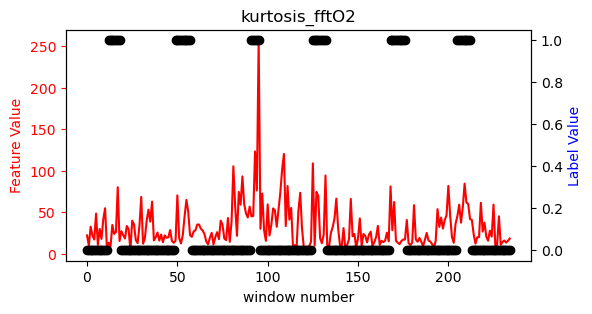

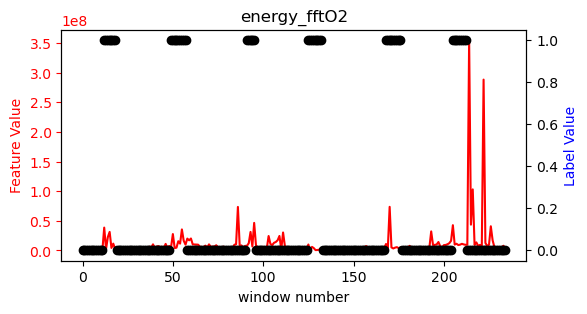

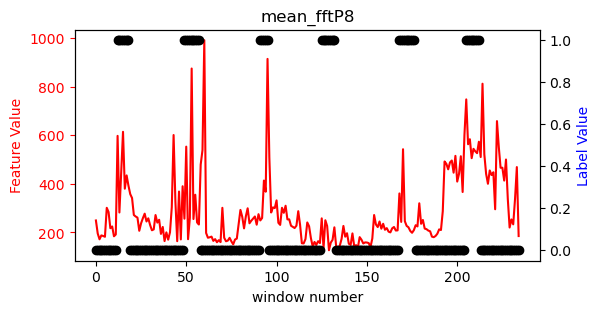

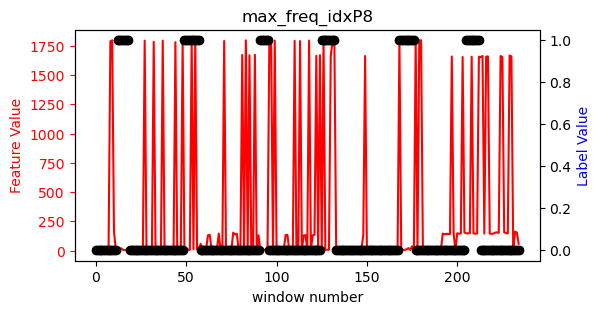

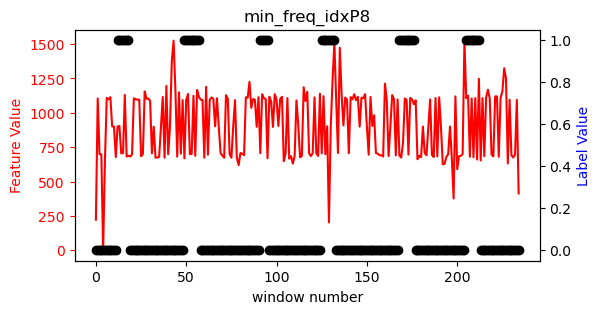

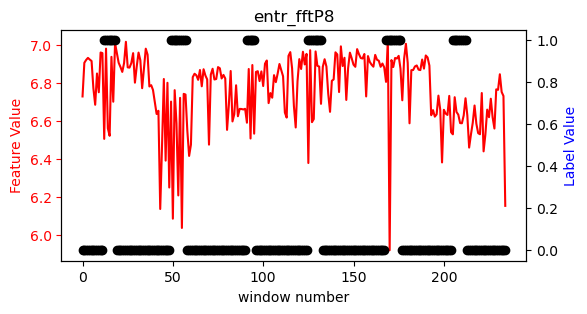

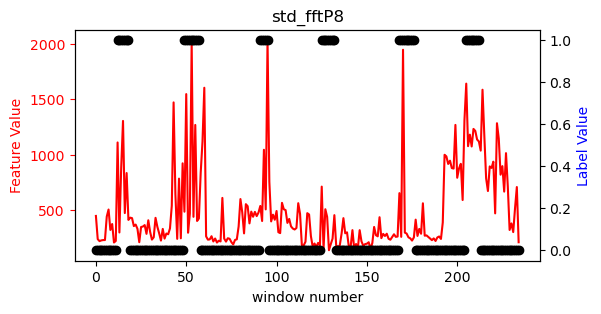

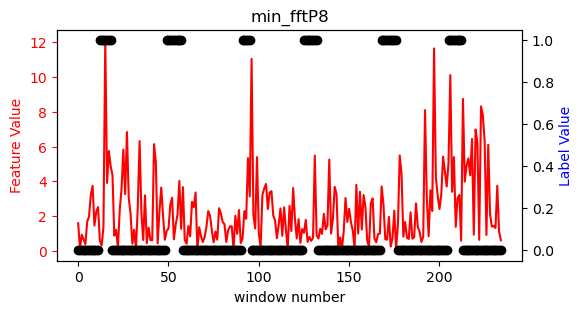

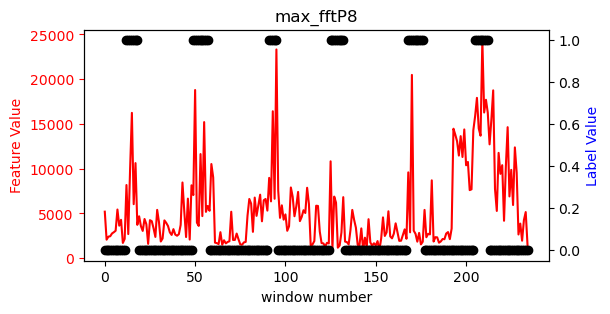

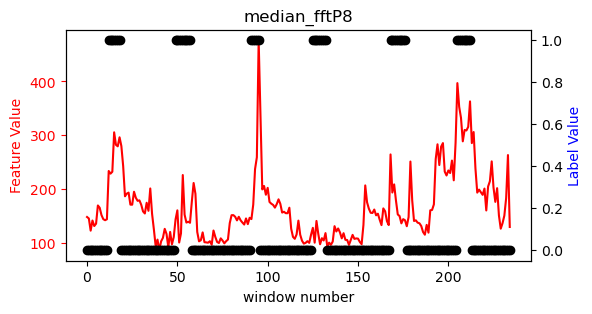

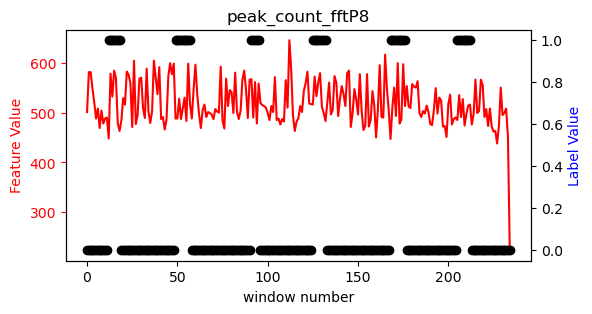

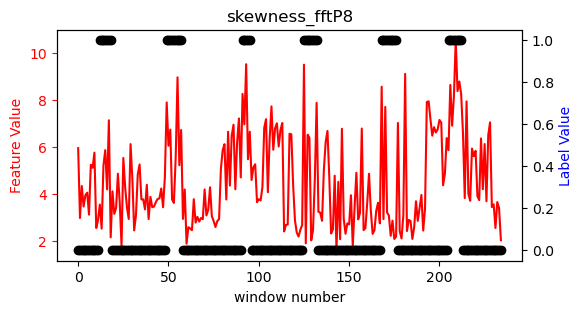

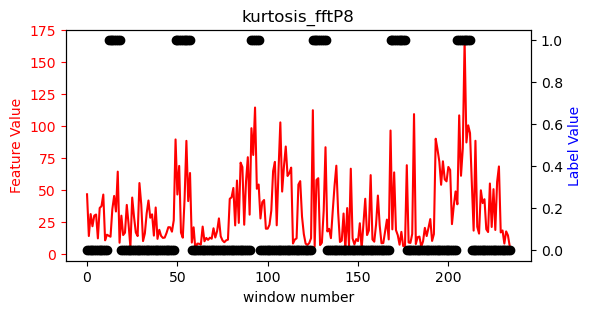

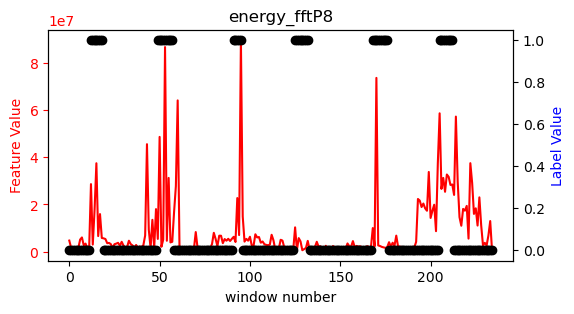

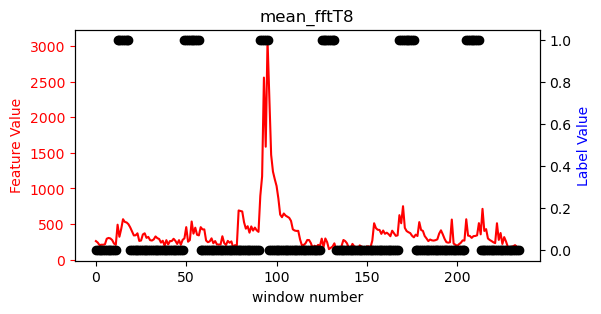

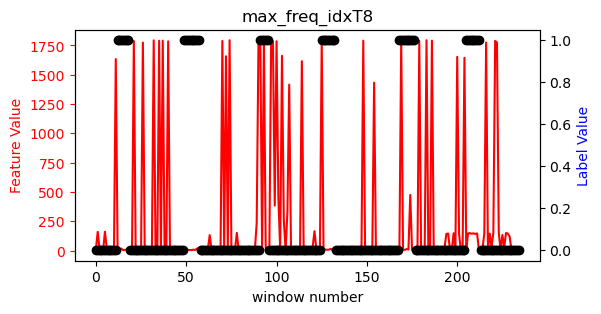

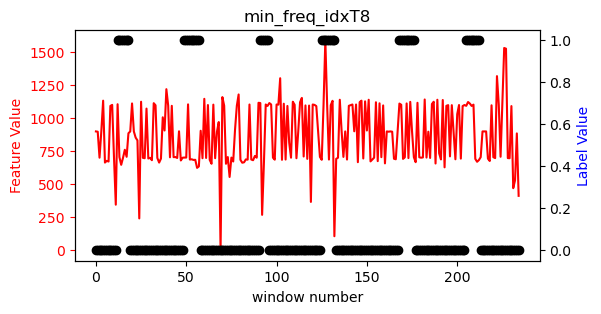

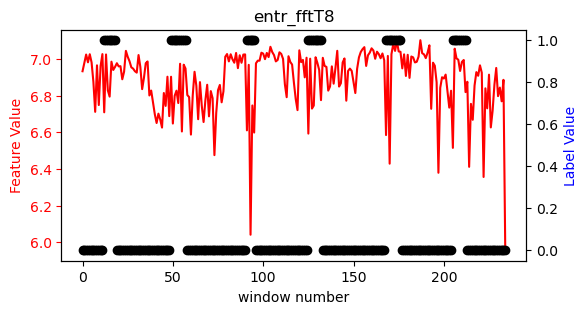

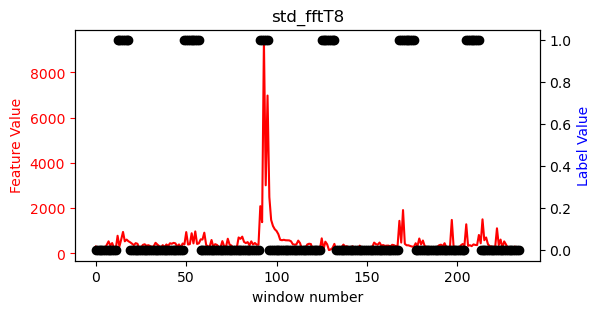

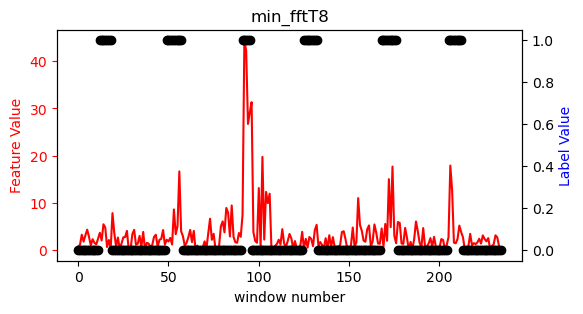

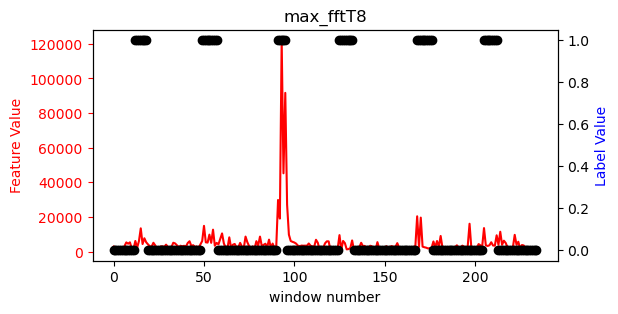

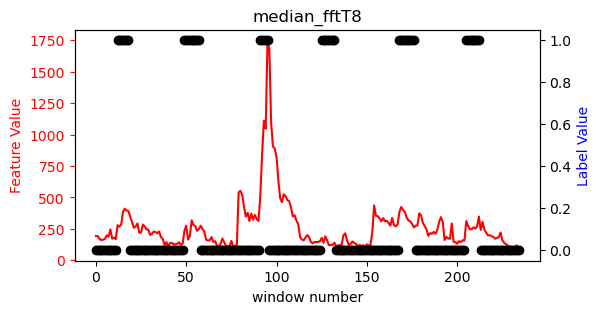

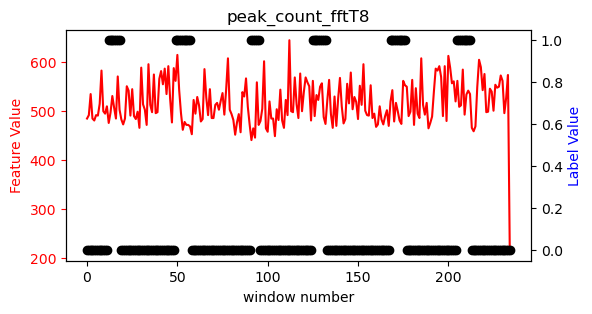

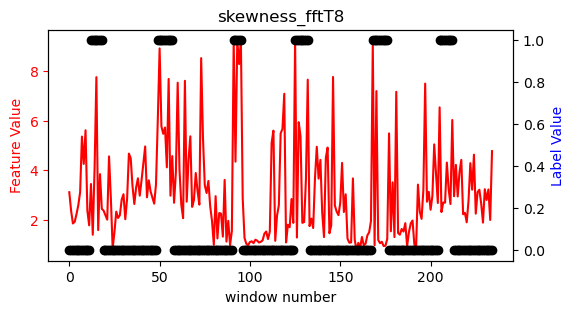

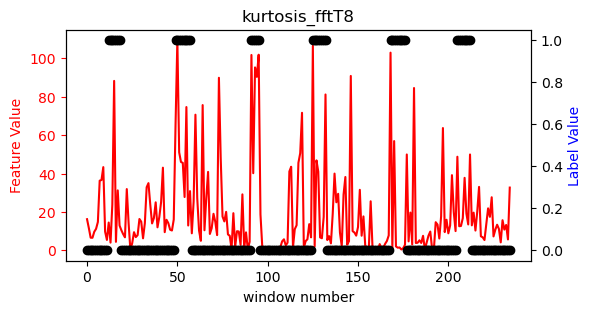

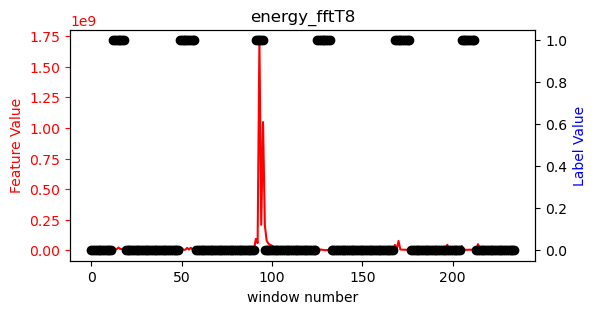

In [19]:
for i in features.columns:
    fig, ax1 = plt.subplots(figsize=(6, 3))
    # Plot the first data on the first axes
    ax1.plot(features[i],'r',linewidth=1.5)
    ax1.set_xlabel('window number')
    ax1.set_ylabel('Feature Value', color='red')
    ax1.tick_params('y', colors='red')
    ax2 = ax1.twinx()
    # Plot the second data on the second axes
    ax2.plot(label_list,'o', color='black')
    ax2.set_ylabel('Label Value', color='blue',)
    #ax2.tick_params('y', colors='blue')
    plt.title(i)
    plt.show()

              precision    recall  f1-score   support

           0       0.99      0.91      0.95       101
           1       0.92      0.99      0.95       102

    accuracy                           0.95       203
   macro avg       0.95      0.95      0.95       203
weighted avg       0.95      0.95      0.95       203



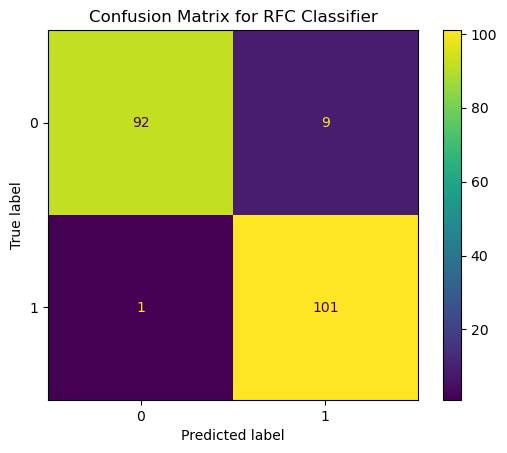

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       122
           1       0.92      0.96      0.94       122

    accuracy                           0.94       244
   macro avg       0.94      0.94      0.94       244
weighted avg       0.94      0.94      0.94       244



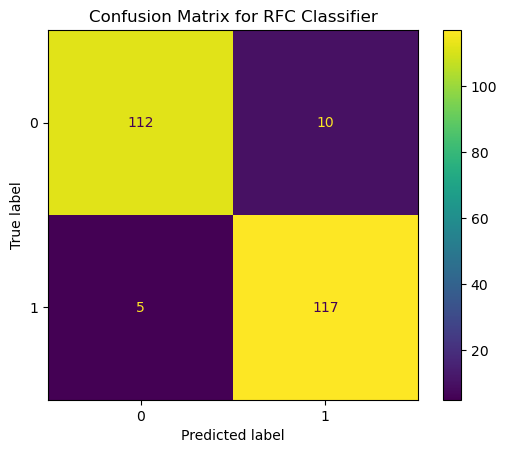

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       149
           1       0.91      0.95      0.93       136

    accuracy                           0.93       285
   macro avg       0.93      0.93      0.93       285
weighted avg       0.93      0.93      0.93       285



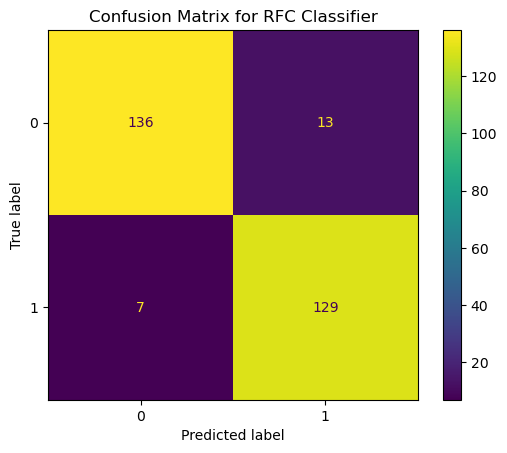

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       148
           1       0.92      0.93      0.92       177

    accuracy                           0.92       325
   macro avg       0.92      0.92      0.92       325
weighted avg       0.92      0.92      0.92       325



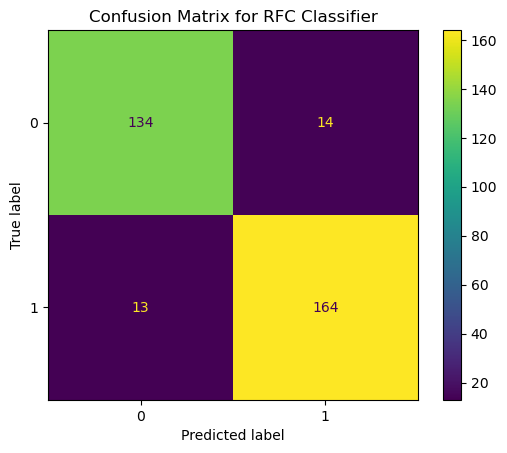

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       173
           1       0.93      0.97      0.95       192

    accuracy                           0.95       365
   macro avg       0.95      0.94      0.94       365
weighted avg       0.95      0.95      0.95       365



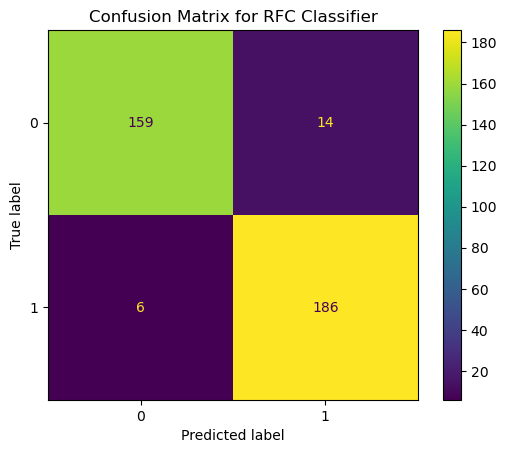

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       194
           1       0.94      0.97      0.95       212

    accuracy                           0.95       406
   macro avg       0.95      0.95      0.95       406
weighted avg       0.95      0.95      0.95       406



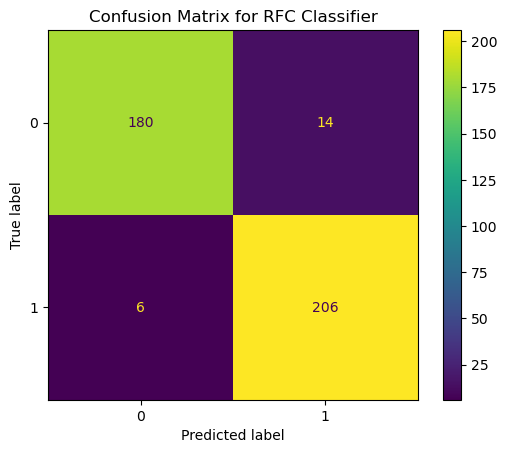

              precision    recall  f1-score   support

           0       0.95      0.88      0.92       233
           1       0.88      0.95      0.91       213

    accuracy                           0.91       446
   macro avg       0.92      0.92      0.91       446
weighted avg       0.92      0.91      0.91       446



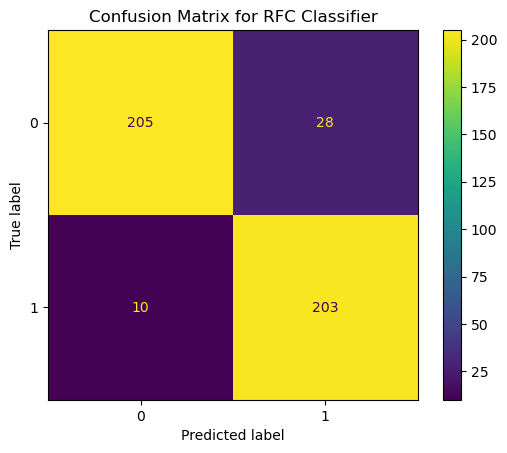

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       239
           1       0.93      0.92      0.92       248

    accuracy                           0.92       487
   macro avg       0.92      0.92      0.92       487
weighted avg       0.92      0.92      0.92       487



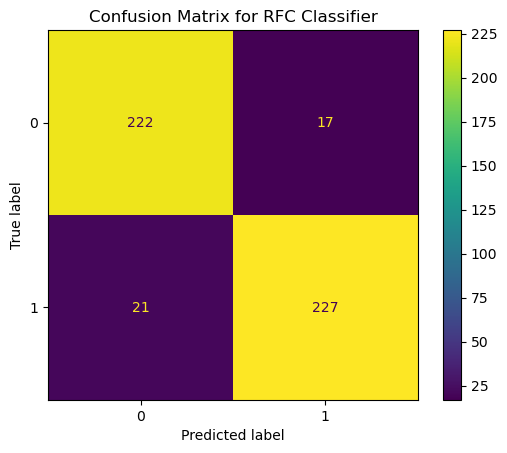

              precision    recall  f1-score   support

           0       0.95      0.92      0.94       251
           1       0.93      0.96      0.94       276

    accuracy                           0.94       527
   macro avg       0.94      0.94      0.94       527
weighted avg       0.94      0.94      0.94       527



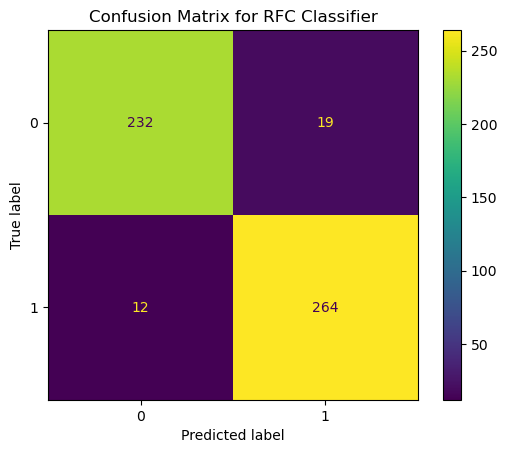

              precision    recall  f1-score   support

           0       0.91      0.92      0.92       261
           1       0.93      0.92      0.93       306

    accuracy                           0.92       567
   macro avg       0.92      0.92      0.92       567
weighted avg       0.92      0.92      0.92       567



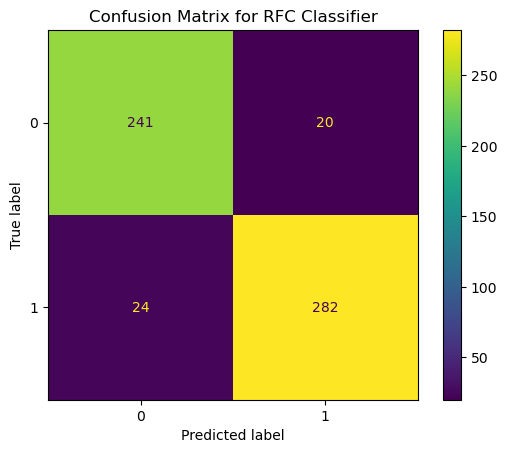

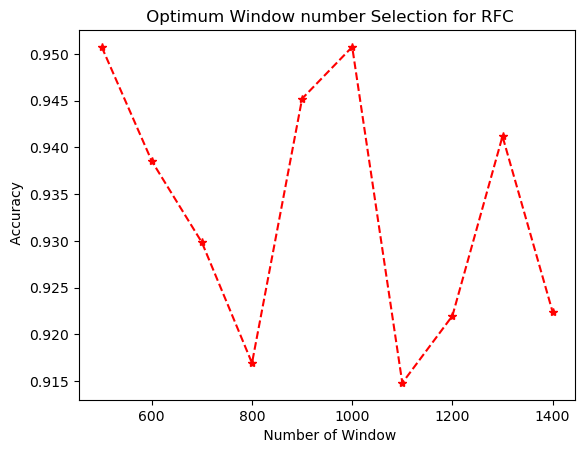

In [11]:
##RFC
no_of_windows=range(500, 1500, 100)
#no_of_windows=[300]
score=np.zeros(len(no_of_windows));
from sklearn.metrics import accuracy_score
for i in range(len(no_of_windows)):
    window_size=int(len(merged_data)/no_of_windows[i])
    
    X, label_list = window_partition(merged_data, window_size, overlap=0, column_names=['AF3', 'F7', 'F3', 'FC5', 'FC6',
       'F4', 'F8', 'AF4'])
    from sklearn.metrics import classification_report as rprt
    smote = SMOTE(random_state=42) 
    scaler=StandardScaler()
    X=scaler.fit_transform(X)
    X_resampled, y_resampled = smote.fit_resample(X, label_list)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25)
    model=rfc(max_depth=12,n_estimators=100  )
    rfc_model=model.fit(X_train, y_train)
    y_prd=model.predict(X_test)
    print(rprt(y_test, y_prd))
    score[i]=accuracy_score(y_test, y_prd)
    cm = confusion_matrix(y_test, y_prd)
    cm_display = metrics.ConfusionMatrixDisplay(cm).plot()
    plt.title("Confusion Matrix for RFC Classifier")
    plt.show()
plt.plot(no_of_windows, score,'--r*' )
plt.xlabel(' Number of Window' )
plt.ylabel(' Accuracy')
plt.title(' Optimum Window number Selection for RFC')
plt.show()
#Retrieve feature importance scores for RFC



              precision    recall  f1-score   support

           0       0.95      0.93      0.94       106
           1       0.93      0.95      0.94        97

    accuracy                           0.94       203
   macro avg       0.94      0.94      0.94       203
weighted avg       0.94      0.94      0.94       203



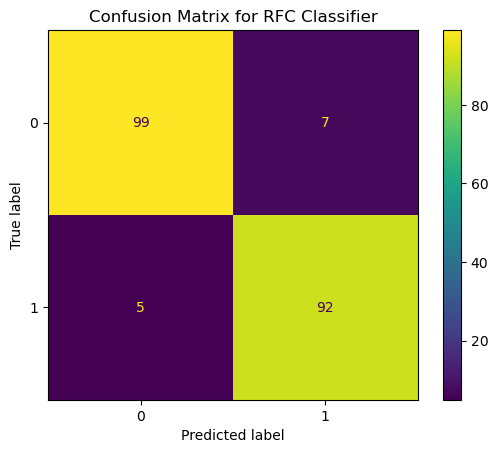

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       124
           1       0.93      0.95      0.94       120

    accuracy                           0.94       244
   macro avg       0.94      0.94      0.94       244
weighted avg       0.94      0.94      0.94       244



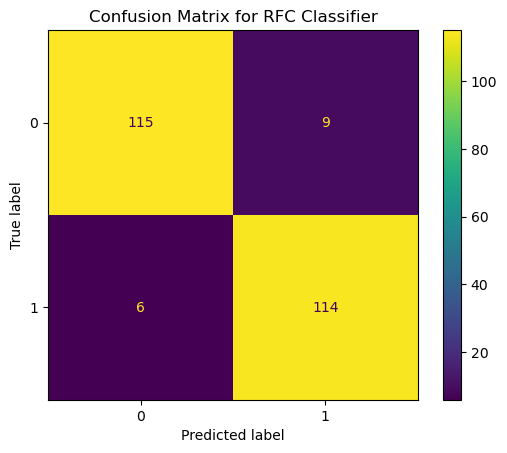

              precision    recall  f1-score   support

           0       0.93      0.92      0.92       133
           1       0.93      0.94      0.93       152

    accuracy                           0.93       285
   macro avg       0.93      0.93      0.93       285
weighted avg       0.93      0.93      0.93       285



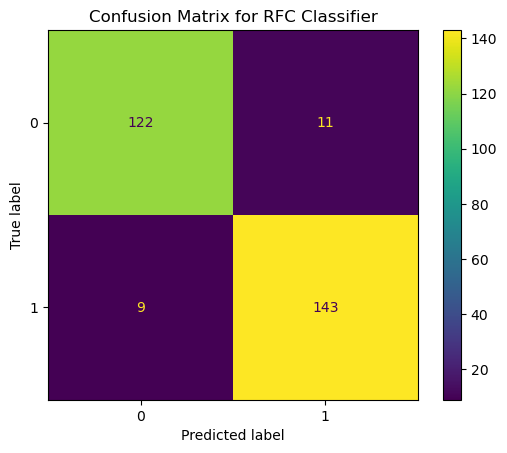

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       166
           1       0.94      0.94      0.94       159

    accuracy                           0.94       325
   macro avg       0.94      0.94      0.94       325
weighted avg       0.94      0.94      0.94       325



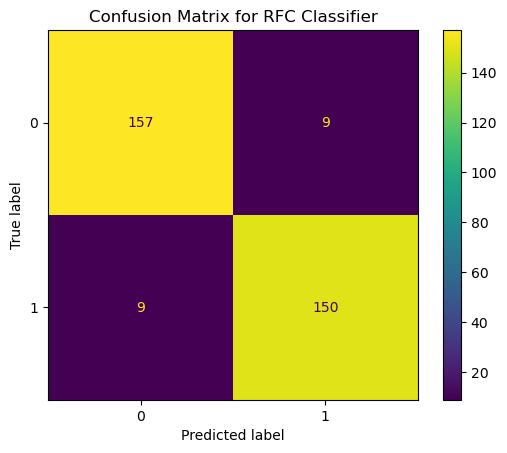

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       195
           1       0.91      0.93      0.92       170

    accuracy                           0.92       365
   macro avg       0.92      0.92      0.92       365
weighted avg       0.92      0.92      0.92       365



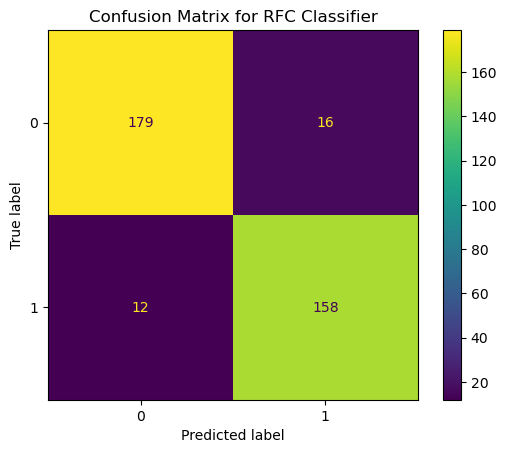

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       215
           1       0.94      0.93      0.93       191

    accuracy                           0.94       406
   macro avg       0.94      0.94      0.94       406
weighted avg       0.94      0.94      0.94       406



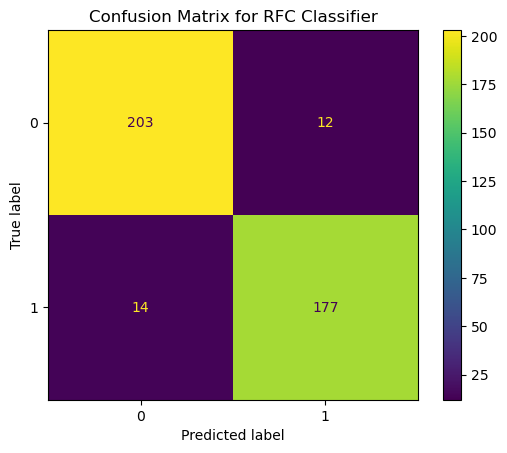

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       208
           1       0.92      0.92      0.92       238

    accuracy                           0.91       446
   macro avg       0.91      0.91      0.91       446
weighted avg       0.91      0.91      0.91       446



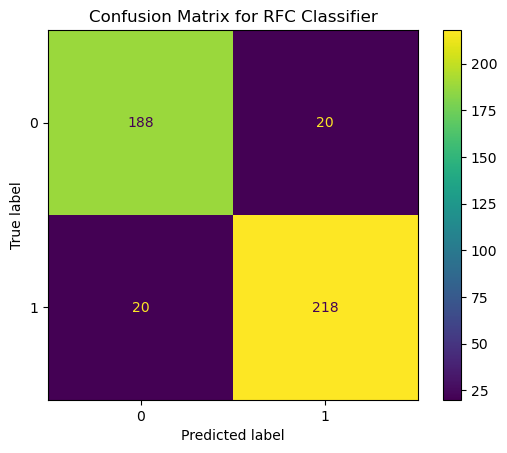

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       246
           1       0.94      0.90      0.92       241

    accuracy                           0.92       487
   macro avg       0.92      0.92      0.92       487
weighted avg       0.92      0.92      0.92       487



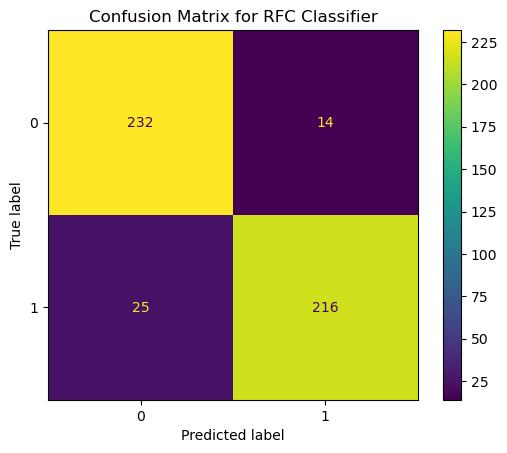

              precision    recall  f1-score   support

           0       0.92      0.91      0.91       254
           1       0.92      0.93      0.92       273

    accuracy                           0.92       527
   macro avg       0.92      0.92      0.92       527
weighted avg       0.92      0.92      0.92       527



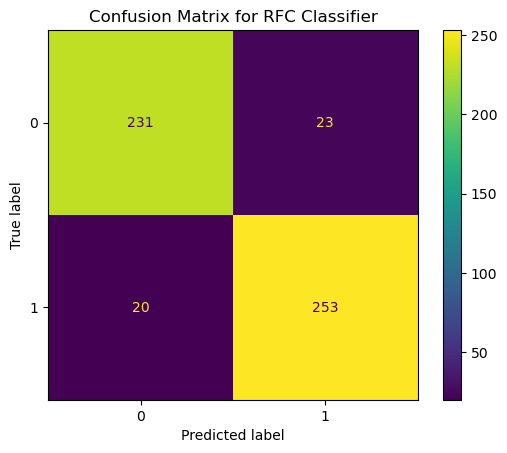

              precision    recall  f1-score   support

           0       0.92      0.89      0.90       278
           1       0.90      0.92      0.91       289

    accuracy                           0.91       567
   macro avg       0.91      0.91      0.91       567
weighted avg       0.91      0.91      0.91       567



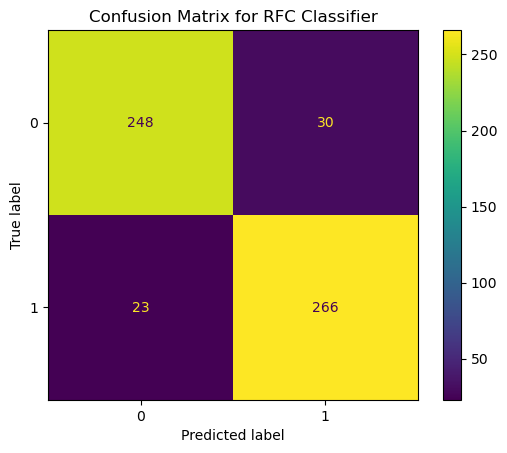

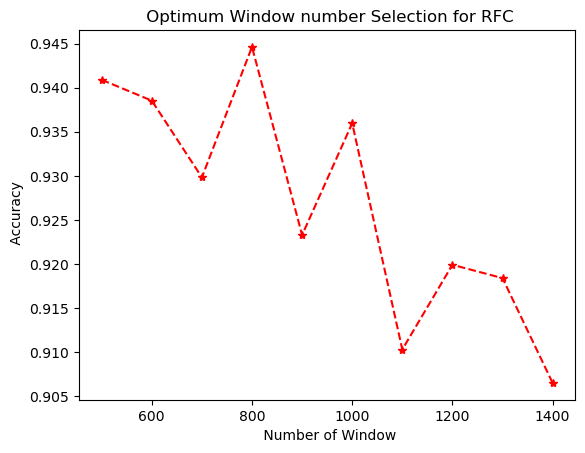

In [21]:
##RFC
no_of_windows=range(500, 1500, 100)
#no_of_windows=[300]
score=np.zeros(len(no_of_windows));
from sklearn.metrics import accuracy_score
for i in range(len(no_of_windows)):
    window_size=int(len(merged_data)/no_of_windows[i])
    
    X, label_list = window_partition(merged_data, window_size, overlap=0, column_names=['T7', 'P7', 'O1', 'O2', 'P8', 'T8'])
    from sklearn.metrics import classification_report as rprt
    smote = SMOTE(random_state=42) 
    scaler=StandardScaler()
    X=scaler.fit_transform(X)
    X_resampled, y_resampled = smote.fit_resample(X, label_list)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25)
    model=rfc(max_depth=12,n_estimators=100  )
    rfc_model=model.fit(X_train, y_train)
    y_prd=rfc_model.predict(X_test)
    print(rprt(y_test, y_prd))
    score[i]=accuracy_score(y_test, y_prd)
    cm = confusion_matrix(y_test, y_prd)
    cm_display = metrics.ConfusionMatrixDisplay(cm).plot()
    plt.title("Confusion Matrix for RFC Classifier")
    plt.show()
plt.plot(no_of_windows, score,'--r*' )
plt.xlabel(' Number of Window' )
plt.ylabel(' Accuracy')
plt.title(' Optimum Window number Selection for RFC')
plt.show()
#Retrieve feature importance scores for RFC



mean_fftT7: 0.022767944573783484
max_freq_idxT7: 0.012227545147632463
min_freq_idxT7: 0.010278093577804626
entr_fftT7: 0.009719488380788358
std_fftT7: 0.01635040615913236
min_fftT7: 0.011813492711834182
max_fftT7: 0.029070500476761373
median_fftT7: 0.020768875572903536
peak_count_fftT7: 0.008985648073935787
skewness_fftT7: 0.029313576000004487
kurtosis_fftT7: 0.0391488248401565
energy_fftT7: 0.017502247790201285
mean_fftP7: 0.018585191243194184
max_freq_idxP7: 0.009497191880982195
min_freq_idxP7: 0.00931888616805184
entr_fftP7: 0.010785165968128316
std_fftP7: 0.012372975296440013
min_fftP7: 0.008305737087500036
max_fftP7: 0.00929379774431982
median_fftP7: 0.027982534427896836
peak_count_fftP7: 0.006867743007579304
skewness_fftP7: 0.007281073823679045
kurtosis_fftP7: 0.007600551817783604
energy_fftP7: 0.0128811842907039
mean_fftO1: 0.015566970956895593
max_freq_idxO1: 0.009652763185387724
min_freq_idxO1: 0.010431392663479769
entr_fftO1: 0.009742497536159604
std_fftO1: 0.0120261651909694

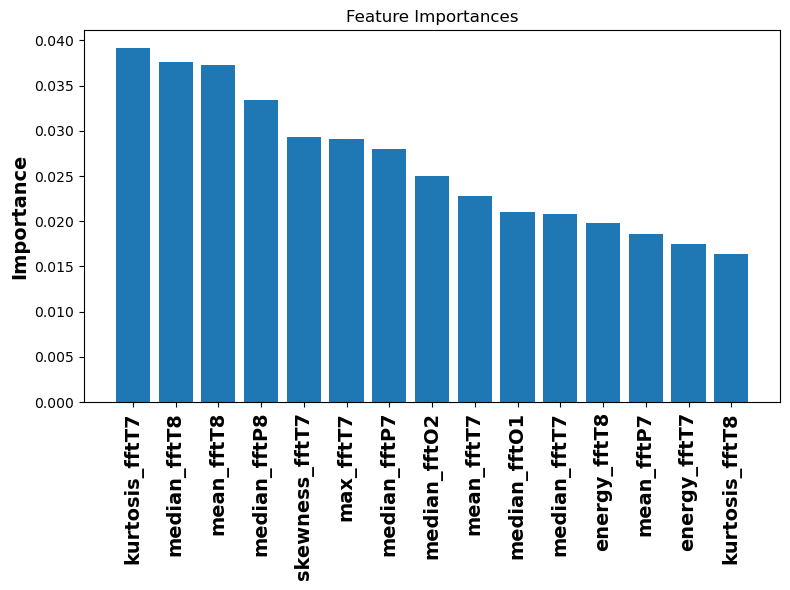

In [22]:
#Retrieve feature importance scores for RFC

feature_importances =  rfc_model.feature_importances_
normalized_importances = feature_importances / np.sum(feature_importances)


# Print the normalized feature importances
for feature_name, importance in zip(cols, feature_importances):
    print(f'{feature_name}: {importance}')
    
feature_names = cols
importances = normalized_importances
# print(importances)
indices = np.argsort(importances)[::-1]
sorted_feature_names = [feature_names[i] for i in indices]
sorted_importances = importances[indices]

# Plot the feature importances
plt.figure(figsize=(8, 6))
plt.bar(range(15), sorted_importances[0:15])
plt.xticks(range(15), sorted_feature_names[0:15], rotation='vertical',fontsize=14, fontweight='bold' )
plt.ylabel('Importance',fontsize=14, fontweight='bold')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()



In [78]:
print(len(merged_data))/128

422026


TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

In [80]:
len(merged_data)/128/60

54.95130208333333

In [81]:
54/1000


0.054

In [82]:
.054*60

3.2399999999999998